#### 00. Install Dependancies

In [1]:
#%pip install -r requirements.txt

#### 01. Import Dependencies

In [34]:
import os
from enum import Enum
import openai, groq
from pydantic import BaseModel # Helpful for retrive structured output from LLMs
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv

load_dotenv()


True

#### 02. Basic Information

In [3]:
df = pd.read_csv('data/raw/ChurnModelling.csv')
df.head()

,RowNumber,CustomerId,Firstname,Lastname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Grace,Williams,619,France,Female,42.0,2,0.00,1,1,1,101348.88,1
1,2,15647311,David,Jones,608,Spain,Female,41.0,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Hank,Williams,502,France,Female,42.0,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Eva,Taylor,699,France,Female,NaN,1,0.00,2,0,0,93826.63,0
4,5,15737888,Grace,Miller,850,Spain,Female,43.0,2,125510.82,1,1,1,79084.10,0


Nan = Not a number

In [ ]:
# Get the null Values
#df.isnull()

# Sum of nnull values
df.isnull().sum()


RowNumber            0
CustomerId           0
Firstname            7
Lastname             6
CreditScore          0
Geography            0
Gender             108
Age                600
Tenure               0
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

#### 03. Handle Missing Values

##### 03.1 Deletion

**axis = 1 -->** check each **column** and drop if atleast 1 null value consists of </br>
**axis = 0 -->** check each **raw** and drop if atleast 1 null value consists of

In [ ]:
df_cp = df.copy()
df_cp = df_cp.dropna(axis=0)
df_cp
# Dropped 663 rows

,RowNumber,CustomerId,Firstname,Lastname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Grace,Williams,619,France,Female,42.0,2,0.00,1,1,1,101348.88,1
1,2,15647311,David,Jones,608,Spain,Female,41.0,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Hank,Williams,502,France,Female,42.0,8,159660.80,3,1,0,113931.57,1
4,5,15737888,Grace,Miller,850,Spain,Female,43.0,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Jack,Smith,645,Spain,Male,44.0,8,113755.78,2,1,0,149756.71,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Grace,Garcia,771,France,Male,39.0,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Jack,Garcia,516,France,Male,35.0,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Carol,Johnson,709,France,Female,36.0,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Jack,Garcia,772,Germany,Male,42.0,3,75075.31,2,1,0,92888.52,1


In [8]:
10000 - 9337

663

In [ ]:
df_cp = df.copy()
df_cp = df_cp.dropna(axis=1)
df_cp
# Dropped 4 columns

,RowNumber,CustomerId,CreditScore,Geography,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,619,France,2,0.00,1,1,1,101348.88,1
1,2,15647311,608,Spain,1,83807.86,1,0,1,112542.58,0
2,3,15619304,502,France,8,159660.80,3,1,0,113931.57,1
3,4,15701354,699,France,1,0.00,2,0,0,93826.63,0
4,5,15737888,850,Spain,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,771,France,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,516,France,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,709,France,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,772,Germany,3,75075.31,2,1,0,92888.52,1


##### 03.2 Imputation

The possible ways to do this are :
- Filling the missing data with the mean or median value if it's a numerical variable.
- Filling the missing data with mode if it's a categorical value.
- Filling the numerical value with 0 or -999, or some other number that will not occur in the data. This can be done so that the machine can recognize that the data is not real on is different
- Filling the categorical value with a new type for the missing values 

##### 03.2.1 Age

In [11]:
mean = df['Age'].mean()
median = df['Age'].median()
mean = round(mean, 2)

print(f"Mean | Age : {mean}")
print(f"Median | Age : {median}")

Mean | Age : 38.91
Median | Age : 37.0


<Axes: xlabel='Age', ylabel='Count'>

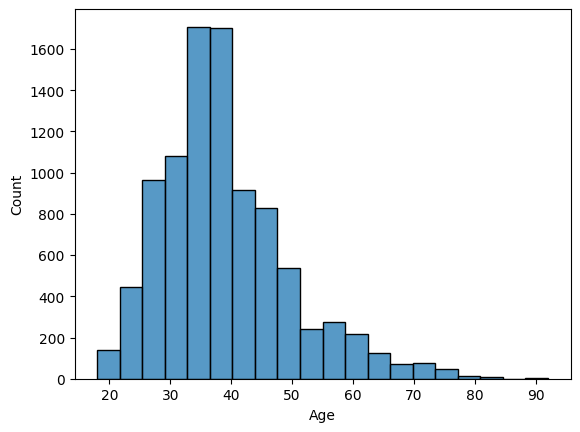

In [13]:
sns.histplot(df['Age'], bins=20)

In [16]:
df_impute = df.copy()

In [18]:
df_impute.loc[:, 'Age'] = df_impute['Age'].fillna(mean)
df_impute.head()

,RowNumber,CustomerId,Firstname,Lastname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Grace,Williams,619,France,Female,42.00,2,0.00,1,1,1,101348.88,1
1,2,15647311,David,Jones,608,Spain,Female,41.00,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Hank,Williams,502,France,Female,42.00,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Eva,Taylor,699,France,Female,38.91,1,0.00,2,0,0,93826.63,0
4,5,15737888,Grace,Miller,850,Spain,Female,43.00,2,125510.82,1,1,1,79084.10,0


In [19]:
df_impute.isnull().sum()

RowNumber            0
CustomerId           0
Firstname            7
Lastname             6
CreditScore          0
Geography            0
Gender             108
Age                  0
Tenure               0
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

##### 3.2.2 Gender

In [35]:
class Gender(str, Enum):
    MALE = "Male"
    FEMALE = "Female"

class GenderPrediction(BaseModel):
    firstname: str
    lastname: str
    pred_gender: Gender

def  predict_gender(
                firstname: str,
                lastname:str
            ):
    prompt = f"""
                What is the most likely gender (Male or Female) for someone with the first name '{firstname}'
                and last name '{lastname}' ?

                Your response only consists of one word: Male or Female
                """
    
    response = groq.Groq().chat.completions.create(
                                                    model='llama-3.3-70b-versatile',
                                                    messages=[{
                                                        "role": "user",
                                                        "content": prompt
                                                    }]
                                                )
    
    predicted_gender = response.choices[0].message.content.strip()
    return predicted_gender

In [36]:
predict_gender("Sahas", "Induwara")

'Male'